# Binary segmentation with Markov random fields, graph cuts and belief propagation

by **Emmanuelle Gouillart**

@EGouillart on Twitter / ``emmanuelle`` on GitHub

Welcome to this tutorial about binary segmentation! Here you will learn about several methods in order to attribute pixels of an image to two different phases, that might correspond for example to cells and background in a biological image, or to two different chemical phases in materials science. The page that you're reading is an **Ipython notebook**, meaning that you can download the file and execute the examples or tinker with the code, if you have an installation of Python and some common scientific modules (NumPy, Matplotlib, scikit-image) on your computer. For one part of this tutorial (graph cuts optimization), you have to install another package to run the code. But don't worry about code installation: you can also enjoy this tutorial by just reading it! Let's get started now.

A common task in image processing is the segmentation of images into a given number of phases. Several information from the image can be used for such a segmentation. First, similar gray-level values are more likely to belong to the same phase; second, neighboring pixels are more likely to belong to the same phase, if the image consists of distinct objects and not of random pixel values. A large class of method exists that leverages these two kinds of information. Here, I will focus on two methods: **graph cuts** optimization, that is a very classical methods in image processing and computer vision, and **belief propagation**, that is perhaps less known to a general audience but is also very interesting. 

Let us start by defining a binary image.

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

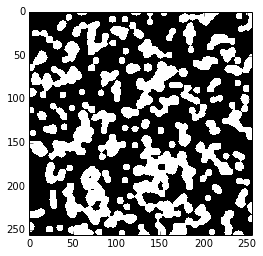

In [2]:
from skimage import filters


def generate_synthetic_data(l_x=128, seed=None, n_pts=25, ndim=2):
    """
    Generates synthetic binary data with blob-like objects.
    """
    rs = np.random.RandomState(seed)
    x, y = np.ogrid[:l_x, :l_x]
    mask = np.zeros((l_x, l_x))
    points = l_x * rs.rand(2, n_pts)
    mask[(points[0]).astype(np.int), (points[1]).astype(np.int)] = 1
    mask = filters.gaussian_filter(mask, sigma=l_x / (4. * np.sqrt(n_pts)))
    mask = mask > mask.mean()
    return mask.astype(np.float)

im = generate_synthetic_data(l_x=256, n_pts=500)
im -= 0.5
im *= 2

plt.imshow(im, cmap='gray', interpolation='nearest')

The image ``im`` is completely binary, but let us suppose that it is corrupted with Gaussian noise. We can do this very easily with NumPy.

<matplotlib.colorbar.Colorbar instance at 0x7f6de1296e18>

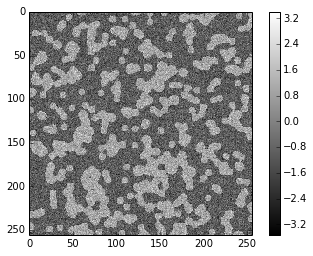

In [3]:
noisy_im = im + 0.6 * np.random.randn(*im.shape)
plt.imshow(noisy_im, cmap='gray', interpolation='nearest')
plt.colorbar()

## Histogram-based thresholding: Otsu's method

Although the contrast is not as good as in the original image, we can still distinguish quite well different grey levels. What if we try to binarize the image using just pixel values, and trying to classify them into two families? ``scikit-image`` provides a function for automatic thresholding and binarization, using Otsu's method.

Otsu threshold: -0.042723
Fraction of errors: 0.050232


<matplotlib.contour.QuadContourSet instance at 0x7f6de017bd88>

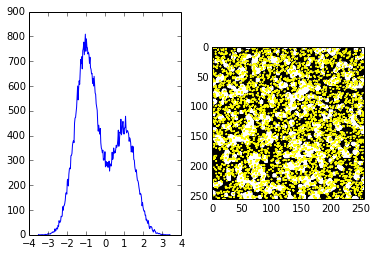

In [4]:
f, (ax1, ax2) = plt.subplots(1, 2)

from skimage import exposure
hi = exposure.histogram(noisy_im)
ax1.plot(hi[1], hi[0])

threshold = filters.threshold_otsu(noisy_im)
print("Otsu threshold: %f" %threshold)
binary_otsu = noisy_im > threshold
errors = np.logical_not(binary_otsu == (im > 0))
segmentation_score = errors.mean()
print("Fraction of errors: %f" %segmentation_score)

ax2.imshow(binary_otsu, cmap='gray')
ax2.contour(errors, colors='yellow')

So, the result is not so bad, but we still get a fraction of the order of 5% pixels that are wrongly attributed. As we can see from the histogram, the two peaks are not so well separated: no wonder that a segmentation based only on pixel values results in some errors. 

Can we do better if we use spatial information about pixels as well? Our eye does it very well, by smoothing together neighboring pixels, so that we can distinguish objects very well despite the presence of noise. A first idea would be to perform a first **denoising** step on the image, by using a filter that averages the value of a pixel with other values of pixels, often neighbors of the pixels. Filtering is a way to make use of the spatial information. Different denoising filters are available in ``scikit-image``, such as median filter, bilateral filter, total-variation denoising, etc. See for example http://scikit-image.org/docs/dev/auto_examples/plot_denoise.html for a comparison of different denoising filters. Denoising will typicall sharpen histogram peaks, so that Otsu thresholding is more accurate on a denoised image. Here, we will employ a different strategy, by trying to use at the same time information on gray values and on spatial proximity, and perform the segmentation in one step.

A classical way to consider this problem is to consider the looked-for solution as a set of random binary variable, and to define a cost function, or energy, associated to realizations of the binary variables. The energy should have two terms: one that favors that pixels have the same sign as in the experimental noisy image, and another term that will penalize neighboring pixels with opposite signs. If we call $x_i$ the value of pixel $i$ in the noisy image, and $s_i$ the binary value that we're looking for, the energy can be defined as
$$E(s_i) = \sum_i (x_i - s_i)^2 - J \sum_{i-j} s_i s_j,$$
where $i-j$ are pairs of neighboring pixels.
Since $s_i^2 = 1$ and $x_i$ is a constant, it is equivalent to use the energy
$$E(s_i) = - \sum_i 2 x_i s_i - J \sum_{i-j} s_i s_j$$

This energy model is known as Ising model in statistical physics (with the $x_i$ from the noisy image corresponding to a frozen external magnetic field, and the $s_i$ being called *spins*), or it's also a common example of *Markov random field*.

## Graph cuts optimization

Graph cuts is a graph-based method to find the configuration corresponding to the minimum of the energy $E$. Graph cuts can be used to solve a variety of computer vision and image processing problems for which an energy is defined (see http://en.wikipedia.org/wiki/Graph_cuts_in_computer_vision). In general, the solution of graph cuts is an approximation of the exact solution corresponding to the minimal energy, but it has been shown that binary denoising can be solved exactly with graph cuts. Here, we use the code of Yuri Boykov [1] and its Python API provided by Andreas Mueller in https://github.com/amueller/gco_python If you wish to use the graph cuts code, go to https://github.com/amueller/gco_python and follow the installation instructions to install the ``pygco`` package.

[1] Boykov, Y., Veksler, O., & Zabih, R. (2001). Fast approximate energy minimization via graph cuts. Pattern Analysis and Machine Intelligence, IEEE Transactions on, 23(11), 1222-1239.

In [5]:
from pygco import cut_simple

Since graph cuts operates on integer images, we need to convert our noisy image to an integer image. We multiply values by 100 in order to get enough sampling information. Then, we define two terms ``unaries`` and ``pairwise`` that correspond to the two terms of the energy.

In [6]:
noisy_im_gco = (100 * noisy_im).astype(np.int32)

In [7]:
unaries = np.dstack([noisy_im_gco, -noisy_im_gco]).copy("C")
J = 1
pairwise = -int(100 * J) * np.eye(2, dtype=np.int32)

In [8]:
result_gco = cut_simple(unaries, pairwise)
errors_gco = np.logical_not(result_gco == (im > 0))
print('Fraction of errors: %f' %errors_gco.mean())

Fraction of errors: 0.005234


<matplotlib.contour.QuadContourSet instance at 0x7f6ddb31b290>

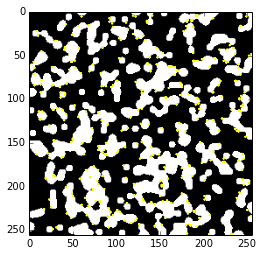

In [9]:
plt.imshow(result_gco, cmap='gray')
plt.contour(errors_gco, colors='yellow')

Using graph cuts, we have reduced the number of segmentation errors by a factor of 10! Not bad, huh? Most wrong pixels lie on domain boundaries, where it is more difficult to use information from neighboring pixels. 

Graph cuts is an awesome algorithm, that is both flexible, accurate and fast, with a lot of proven results about the accuracy of solutions. One downside is that the algorithm is a bit difficult to understand in details and to code. If you're just planning to use existing code, then the code of Boykov, that has a Matlab and a Python API (the latter by Andy Mueller) will just work great for you. 

## Belief propagation

We will now consider a different method called **belief propagation** (http://en.wikipedia.org/wiki/Belief_propagation). Compared to graph cuts that find the image that minimizes the energy $E$, belief propagation takes a slightly different approach: it estimates the expectation of every pixel under the probability distribution $\exp(-E)$ (in statistical physics, taking the probability of a configuration to be the log of its energy is called the *canonical formalism*). Note that choosing the configuration with the minimum energy corresponds to choosing the solution with the maximal probability. Now, since the energy $E$ is the sum of different terms corresponding to pixel terms and pairs terms, the probability of a configuration is the product of different factors defined on pixels and neighbors pairs. 

$$ p(\{s_i\}) = \prod_{i} e^{s_i x_i} \prod_{i-j} e^{J s_i s_j} $$

To compute the marginal probability of a pixel, we could consider all possible configurations of binary images, and compute the expectation of the pixel value by summing over $s_i p(\{s_j\})$. For an image of $N$ pixels, there are $2^N$ possible configurations: even for small images, such sums would take ages to compute.

However, notice that if each term in the product in the definition of $p$ was independent of the others, the sum over all configurations would be much easier to perform because we could separate the sum into sum over groups of pixels. Belief propagation uses a similar idea, that is, to write the marginal probability of a pixel as a product of terms that are supposed to be known, and that are defined from other terms that one also supposes to be known, with closure relations imposed by the factorized structure of the probability distribution.

Let us known give a rough sketch of the algorithm. First, note that $p$ defines a graphical model composed of variables (the pixels) and factors that involve one or several (here, two forming a pair) pixels. The graphical model is depicted in the figure below.
<img src="factor_graph_denoising.png" width=300>
Here, these factors are either the unary terms or the pair terms. The graphical model is obtained by adding an edge between factor $\mu$ and pixel $i$ if pixel $i$ is found in factor $\mu$: it's a bipartite graph where factors are linked only to pixels,and vice versa. Then, we define the *message* from factor $\mu$ to pixel $i$ $m_{\mu\rightarrow i} (s_i)$ as the marginal probability of pixel $i$ if all other factors involving $i$ are removed from the graph, that is, if we remove all edges linked to pixel $i$, but the one linked to factor $\mu$. Conversely, we define the message from pixel $i$ to message $\mu$ as the marginal probability of pixel $i$ in the absence of factor $\mu$, that is if we remove the edge linking $i$ and $\mu$. 
<img src="factor_graph_messages.png" width=500>

The belief propagation equations are closure equations defined as 
$$ m_{j \to \nu} (s_j) \propto \prod_{\mu \in j \neq \nu} m_{\mu \to j}  (s_j)$$
and
$$ m_{\mu \to i} (x_i) \propto \sum_{x_j; j \in \mu \neq i} \mathcal{P}_\mu (\{x_j\}, x_i) \prod_{j\in\mu\neq i}
m_{j \to \mu} (s_j).$$
The above equations are exact if the graph has a tree structure, for which cutting an edge results in two independent parts of the graph. In a generic graph, loops can be present in the graph, so that the above expressions are only approximately true. Never mind, we'll suppose that this set of equations defines a set of messages that we wish to compute. Belief propagation equations are fixed-point equations, so that a solution can be obtained by iterating the equations (messages can be initialized with constant or random values, for example). Note that convergence is not guaranteed and that for some problems, it is necessary to update only partially the values of the messages at each iteration (using a linear combination of the old and the new value), in order to reach convergence. If a stationary point of belief propagation equations is reached, then there exist rigorous results showing that a belief propagation solution  is a configuration of maximum probability for a distribution of probability that approximates the original distribution, using the so-called Bethe energy [Yedidia2003][1].

[1] Yedidia, J. S., Freeman, W. T., & Weiss, Y. (2003). Understanding belief propagation and its generalizations. Exploring artificial intelligence in the new millennium, 8, 236-239.

Let us now write belief propagation equations for our specific binary denoising problem. First, let me introduce a little trick that physicists are very fond of. Instead of computing $m_{\mu \to i}(+1)$ and $m_{\mu \to i}(-1)$, we define 
$$m_{\mu \to i}(s_i) = \frac{e^{h_{\mu \to i} s_i}}{e^{h_{\mu \to i}} + e^{-h_{\mu \to i}}}.$$ 
Therefore, instead of computing two values for $m_{\mu \to i}(1)$ and $m_{\mu \to i}(-1)$, we just have to compute $h_{\mu \to i} = \mathrm{arctanh}{\langle m_{\mu \to i} \rangle}$. 

Using such notations, belief propagation equations write (neglecting constant normalization terms):
$$m_{i \to ij} = \prod_{k \neq j} m_{ik \to i} m_i $$
$$m_{ij \to i} = \sum_{s_j} e^{J s_i s_j} m_{j \to ij}(s_j) = \sum_{s_j} e^{J s_i s_j} e^{h_{j \to ij}s_j} $$
Here $m_i$ corresponds to the message sent by the noisy image pixel, that is the data term, and we write $\mu = ij$ for the factor corresponding to the edge $ij$.

The first equation is equivalent to
$$h_{i \to ij} = \sum_{k \neq j} h_{ik \to i} + h_i$$

The second equation can be transformed using 
$$\mathrm{tanh}(h_{ij \to i}) = \langle m_{ij \to i} \rangle = \sum_{s_i}\sum_{s_j} s_i e^{J s_i s_j} e^{h_{j \to ij}s_j}.$$
Summing first over $s_i$, and using the trick $\mathrm{tanh}(J s_j) = s_j \mathrm{tanh}(J)$ ($s_j$ being a sign, +1 or -1), one obtains
$$\mathrm{tanh}(h_{ij \to i}) = \mathrm{tanh}(J) \mathrm{tanh}(h_{j \to ij}).$$

These equations are implemented below (using the convention $h_{i \to ij} \to h_{i \to ij} - h_i$ for convenience).

In [10]:
import math


def _compute_pixel_to_factors(edges_to_pixels, im):
    """
    Compute the messages from pixels to factors, using the messages
    from factors to pixels (including the frozen field given by the
    image values, corresponding to unary factors).

    The computation is done for the field associated to the messages, hence 
    a sum is done on the fields (corresponding to the product of the messages). 
    """
    pixels_to_edges = np.empty_like(edges_to_pixels)
    h_sum = edges_to_pixels.sum(axis=0)
    h_sum += im
    for mu_to_px, px_to_mu in zip(edges_to_pixels, pixels_to_edges):
        px_to_mu[:] = h_sum - mu_to_px
    return pixels_to_edges, h_sum


def BP_mrf(im, J, n_step=10):
    """
    Binary segmentation of a noisy image, computed from the a-posteriori mean
    pixel value in a binary Markov random field (mrf). The mean a-posteriori is
    computed using the belief propagation algorithm.

    Parameters
    ----------

    im : 2-D ndarray
        Image to be segmented

    J : float
        coupling between neighbors. The higher J, the more interaction between
        neighbors.

    n_step : int
        number of iterations of the belief-propagation fixed-point equations

    Returns
    -------

    res : ndarray
        binary segmentation (of -1 and 1s)
    """
    thJ = math.tanh(J/2.)
    n_edges = 2 * im.ndim  # 4-connectivity in 2-D
    total_shape = tuple([2, n_edges] + list(im.shape))
    edges_to_pixels, pixels_to_edges = np.zeros(total_shape)
    sums = []
    for i in range(n_step):
        # up direction
        edges_to_pixels[0][1:] = np.arctanh(thJ * np.tanh(im[:-1] +
                                            pixels_to_edges[0][:-1]))
        # down 
        edges_to_pixels[1][:-1] = np.arctanh(thJ * np.tanh(im[1:] +
                                            pixels_to_edges[1][1:]))
        # left
        edges_to_pixels[2][:, 1:] = np.arctanh(thJ * np.tanh(im[:, :-1]
                                                + pixels_to_edges[2][:, :-1]))
        # right
        edges_to_pixels[3][:, :-1] = np.arctanh(thJ * np.tanh(im[:, 1:]
                                                + pixels_to_edges[3][:, 1:]))
        pixels_to_edges, h_sum = _compute_pixel_to_factors(edges_to_pixels, im)
    return h_sum


So this it it! I told you belief propagation was not complicated: we implemented the equations in only a few lines of code! Let's look now at the result of belief propagation.

In [11]:
J = 1
result_bp = np.sign(BP_mrf(noisy_im, J, n_step=50))
errors_bp = np.logical_not(result_bp == im)
print('Fraction of errors: %f' %errors_bp.mean())

Fraction of errors: 0.004959


<matplotlib.contour.QuadContourSet instance at 0x7f6de01876c8>

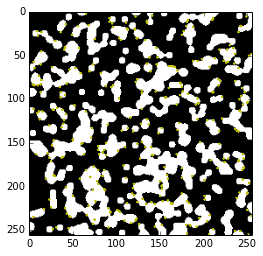

In [12]:
plt.imshow(result_bp, cmap='gray')
plt.contour(errors_bp, colors='y')

Therefore, denoising with belief propagation shows similar performance as graph cuts optimization, in terms of the number of segmentation errors. For further comparison, let us compute the denoising result for different values of the coupling $J$.

In [13]:
errors_gco_list = []
errors_bp_list = []
Js = np.linspace(0.02, 2, 40)
for J in Js:
    pairwise = -int(100 * J) * np.eye(2, dtype=np.int32)
    result_gco = cut_simple(unaries, pairwise)
    errors_gco_list.append(np.logical_not(result_gco == (im > 0)).mean())
for J in Js:
    result_bp = np.sign(BP_mrf(noisy_im, J, n_step=60))
    errors_bp_list.append(np.logical_not((result_bp > 0) == (im > 0)).mean())

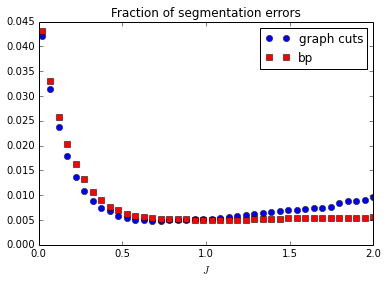

In [14]:
plt.plot(Js, errors_gco_list, 'ob', label='graph cuts')
plt.plot(Js, errors_bp_list, 'sr', label='bp')
plt.xlabel(u'$J$')
plt.title('Fraction of segmentation errors')
plt.legend()

As we can see, the results of belief propagation and graph cuts are quite similar. For both methods, there exists an optimal value of $J$, corresponding to a trade-off between the intensity of denoising and the fidelity to the observed image. For large $J$, however, the fraction of segmentation errors raises more slowly above the optimal value for belief propagation than for graph cuts. This difference might come from the fact that the two methods do not compute the same thing: graph cuts provides a solution of maximum probability, while belief propagation computes the marginal probability of each pixel.  

Therefore, belief propagation is a very interesting method for denoising as well. The devil being in the details, the reader might have noticed one point that is a bit tricky for belief propagation: fixing the number of iterations, or testing the convergence of the fixed-point equations. Let us define a new function where we test the number of flipping pixels at each iterations, that is, pixels for which the sign of $h_i$ changes between two iterations.

In [15]:
def BP_mrf_testflip(im, J, n_step=10):
    """
    Binary segmentation of a noisy image, computed from the a-posteriori mean
    pixel value in a binary Markov random field (mrf). The mean a-posteriori is
    computed using the belief propagation algorithm.

    Parameters
    ----------

    im : 2-D ndarray
        Image to be segmented

    J : float
        coupling between neighbors. The higher J, the more interaction between
        neighbors.

    n_step : int
        number of iterations of the belief-propagation fixed-point equations

    Returns
    -------

    res : ndarray
        binary segmentation (of -1 and 1s)
    """
    thJ = math.tanh(J/2.)
    n_edges = 2 * im.ndim  # 4-connectivity in 2-D
    total_shape = tuple([2, n_edges] + list(im.shape))
    edges_to_pixels, pixels_to_edges = np.zeros(total_shape)
    sums = []
    flip_number = []
    for i in range(n_step):
        # up direction
        edges_to_pixels[0][1:] = np.arctanh(thJ * np.tanh(im[:-1] +
                                            pixels_to_edges[0][:-1]))
        # down 
        edges_to_pixels[1][:-1] = np.arctanh(thJ * np.tanh(im[1:] +
                                            pixels_to_edges[1][1:]))
        # left
        edges_to_pixels[2][:, 1:] = np.arctanh(thJ * np.tanh(im[:, :-1]
                                                + pixels_to_edges[2][:, :-1]))
        # right
        edges_to_pixels[3][:, :-1] = np.arctanh(thJ * np.tanh(im[:, 1:]
                                                + pixels_to_edges[3][:, 1:]))
        pixels_to_edges, h_sum_new = _compute_pixel_to_factors(edges_to_pixels, im)
        if i >= 1:
            flip_number.append(np.logical_not(np.sign(h_sum_new) == np.sign(h_sum)).sum())
        h_sum = h_sum_new
    return h_sum, flip_number


In [16]:
result_bp, flip_number_p2 = BP_mrf_testflip(noisy_im, 0.2, n_step=50)
result_bp, flip_number_p4 = BP_mrf_testflip(noisy_im, 0.4, n_step=50)
result_bp, flip_number_1 = BP_mrf_testflip(noisy_im, 1, n_step=50)
result_bp, flip_number_2 = BP_mrf_testflip(noisy_im, 2, n_step=50)

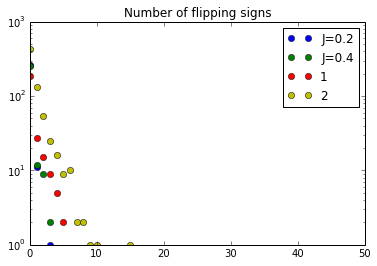

In [17]:
plt.semilogy(flip_number_p2, 'ob', label='J=0.2')
plt.semilogy(flip_number_p4, 'og', label='J=0.4')
plt.semilogy(flip_number_1, 'or', label='1')
plt.semilogy(flip_number_2, 'oy', label='2')
plt.title('Number of flipping signs')
plt.legend()

We see that for the low values of $J$, the number of flipping pixels goes to zero in a handful of iterations. For values of $J$ larger than the optimal value (in terms of segmentation errors), some pixels keep flipping from one sign to the other. Such pixels correspond to pixels for which there is an important uncertainty about the sign. Despite these flipping signs, the solution might be as good as for another value of $J$ for which convergence is reached fast. Hence, determining a good stopping criterion is not completely obvious.

Finally, let us comment on the effect of the spatial regularization term $J$. Looking at the number of segmentation errors, one might think that changing the value of $J$ does not change much the result of belief propagation. This impression comes from the fact that we use belief propagation to compute the binary segmentation, considering only the *sign* of marginal probabilities of pixels. Looking at the (float) marginal probabilities, we observe that the absolute values of $h$ (remember that the marginal probability is proportional to $\mathrm{tanh}(h)$) are higher, meaning that there is less uncertainty on pixel values if they are more constrained by their neighbors.  

1.85531810789


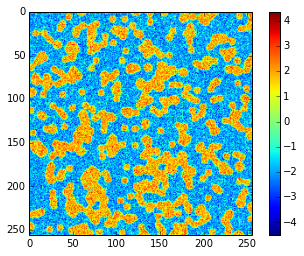

In [18]:
result_bp = BP_mrf(noisy_im, 0.5, n_step=50)
plt.imshow(result_bp); plt.colorbar()
print(result_bp.std())

3.59488287362


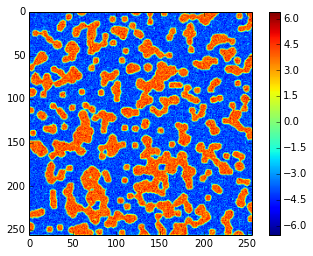

In [19]:
result_bp = BP_mrf(noisy_im, 1.5, n_step=50)
plt.imshow(result_bp); plt.colorbar()
print(result_bp.std())

## Expectation-maximization

For most images, we don't know in advance grey values corresponding to the different phases (in the looked-for image). In particular, such values seldom take the convenient symmetric values of +1 and -1. Let us call these values $v_0$ and $v_1$. If $v_0$ and $v_1$ are known, it is possible to rescale the noisy image so that the values of $s_i$ are +1 and -1. The expectation maximization algorithm (http://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm) is a powerful method to iteratively estimate $(v_0, v_1)$ and denoise the image at the same time. Inside one iteration of expectation-maximization, one supposes that $v_0$ and $v_1$ are known, then belief propagation denoising is performed using such values. The trick is, that from the binary segmentation it is possible to compute the average of the two phases and to update the estimation of $v_0$ and $v_1$. Iterating this process converges fast to a good estimation of $v_0$ and $v_1$, and an accurate denoising. As a starting point, $v_0$ and $v_1$ are estimated using grey values of the noisy images (and not using spatial information about the pixels), thanks to the Gaussian mixture model estimator (GMM) from **scikit-learn**.

In [20]:
from sklearn import mixture

def BP_mrf_em(im, J, n_em_step=5, subsample_factor=2):
    """
    Binary segmentation of noisy images with two phases.

    Uses expectation-maximization to compute the two values corresponding
    to the two phases.

    Parameters
    ----------

    im : 2-D or 3-D ndarray
        Image to be segmented

    J : float
        coupling between neighbors. The higher J, the more interaction between
        neighbors.

    n_em_step : int, optional
        number of expectation-maximization steps to compute the mean values of 
        the two phases

    subsample_factor : int, optional
        take only one pixel out of `subsample_factor` when computing the
        initial guess for the values of the two phases, in order to save computing time.

    Returns
    -------
    
    res : ndarray
        binary segmentation (-1 and 1)

    """
    gmm = mixture.GMM(n_components=2)
    gmm.fit(im.ravel()[::subsample_factor, np.newaxis])
    v_0, v_1 = gmm.means_.ravel()
    if v_1 < v_0:
        tmp = v_1
        v_1 = v_0
        v_0 = tmp
    print v_0, v_1
    for i in range(n_em_step):
        im_normalized = 2./ (v_1 - v_0) * im + 1 - 2 * v_1 / (v_1 - v_0)
        res = np.sign(BP_mrf(im_normalized, J, n_step=20))
        v_0 = im[res==-1].mean()
        v_1 = im[res==1].mean()
        print v_0, v_1
    return res

<matplotlib.colorbar.Colorbar instance at 0x7f6dd2ac17a0>

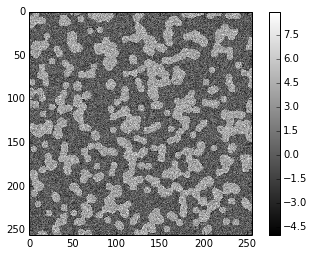

In [21]:
im = generate_synthetic_data(l_x=256, n_pts=500)
im *= 4 # True values of the phases are 0 and 4
noisy_im = im + 1.2 * np.random.randn(*im.shape)
plt.imshow(noisy_im, cmap='gray', interpolation='nearest'); plt.colorbar()

In [22]:
res_bp_em = BP_mrf_em(noisy_im, 1, n_em_step=5, subsample_factor=2)

0.0119272685261 4.01113155274
0.00143221604988 3.99946567599
0.0010056197111 3.9987023948
0.0010056197111 3.9987023948
0.0010056197111 3.9987023948
0.0010056197111 3.9987023948


Note that the convergence to the true values of the phases is very fast, thanks to the quite accurate first guess from the GMM estimator.

This is the end of this tutorial, we hope that you enjoyed it!